In [163]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
import keras

In [164]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

if not (os.path.isdir(hp.mels_dir)):
    os.mkdir(hp.mels_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mels_dir, hp.mels_dir))
    
if not (os.path.isdir(hp.mags_dir)):
    os.mkdir(hp.mags_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mags_dir, hp.mags_dir))

In [165]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [166]:
fnames, texts, secs, text_lengths = [], [], [], []
char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    encodedText = [char2idx[char] for char in text]
    encodedText = np.array(encodedText, np.int32).tostring()
    
    fnames.append(fname); 
    texts.append(encodedText)
    secs.append(float(sec)); 
    text_lengths.append(len(encodedText))
    
# fnames = np.asarray(fnames)
# texts = np.asarray(texts)
# secs = np.asarray(secs)

100%|██████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 9890.55it/s]


In [167]:
# text_lengths

In [168]:
fnames_tensor = tf.convert_to_tensor(fnames)
texts_tensor = tf.convert_to_tensor(texts)

In [169]:
num_epochs = 1
dataset = tf.data.Dataset.from_tensor_slices(tuple([fnames_tensor, texts_tensor])).shuffle(fnames_tensor.shape[0]).repeat(num_epochs)

In [170]:
iterator = dataset.make_one_shot_iterator()
file_name, text = iterator.get_next()
text_decoded = tf.decode_raw(text, tf.int32)

In [171]:
with tf.Session() as sess:    
    for i in range(3):
        f, t = sess.run([file_name, text_decoded])
        print(f)
        print(t)

b'3/3_2925.wav'
[ 2 21  0  9 20  4 40  8 25  7 24  0  5 33  3 21  1 20  0  9 20  4  0  6
 28  8 26 52]
b'4/4_3834.wav'
[ 2 21  0  8 28  7 10 20  4 40  5  8 40  0  5 34  1 20  0  9 20  4  5 28
  7  3 30 18  8 24 54]
b'3/3_1631.wav'
[ 2 20  2 38  2  0  2 33  1 33  2  1 20  0  3 28  8 29  3 20  4  4 20  1
 28  0  7 28  4 40 10 40  2 38  2  0  1 24  7  8 38  4  0  3 38  4  8 24
 18  3 20 52]


In [172]:
#Random Selection
# randIdx = np.random.choice(range(len(lines)), 20)
# randIdx.sort()
# print(randIdx)

# fnames = fnames[randIdx]
# texts = texts[randIdx]
# secs = secs[randIdx]

In [173]:
maxLen, minLen = max(text_lengths), min(text_lengths)

In [174]:
def spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def mel_spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0, n_mels = hp.n_mels)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def true_spectrogram(wav, nsc, nov):
    
    
    S = librosa.core.stft(wav, n_fft=nsc, hop_length=nov)
    Sxx = abs(S)
    dbS = 20 * np.log10(np.maximum(Sxx, hp.eps))
    
    
    return dbS

In [175]:
def learning_rate_decay(init_lr, global_step, warmup_steps=4000.):
    '''Noam scheme from tensor2tensor'''
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

In [176]:
fname = file_name
text = text_decoded

In [177]:
def spectrogram_wrap_up(fname):
    
    fname = fname.decode()
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
    #     if os.path.isfile(mel_path) and os.path.isfile(mag_path):
    if False:

        mag = np.load(mag_path)
        mel = np.load(mel_path) 

    else :

        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag_coef = np.mean(spectrogram(wav, nsc, nov, fs), axis=0)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        mag = true_spectrogram(wav, nsc, nov)

        active = np.where(mag_coef > hp.db_limit)[0]

        first = active[0]
        last = active[-1] + 1

        if first - hp.offset >= 0:
            first = first - hp.offset
        else:
                first = 0

        if last + hp.offset < len(mag_coef):
            last = last + hp.offset
        else:
            last = len(mag_coef)

        mag = mag[:, first:last]
        mel = mel[:, first:last]

        mag = mag / hp.max_db
        mel = mel / hp.max_db

        # Do I really need 
        t = mel.shape[1]
        num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # 0 for multiples

        mel = np.pad(mel.T, [[0, num_paddings], [0, 0]], mode="minimum")
        mag = np.pad(mag.T, [[0, num_paddings], [0, 0]], mode="minimum")

        mel = mel.T
        mag = mag.T

        mel = mel.astype(np.float32)
        mag = mag.astype(np.float32) # Default is float64, type crashes at the Attention Wrapper

        print('{:d}:{:d}'.format(first, last))

        np.save(mag_path, mag)
        np.save(mel_path, mel)

#     print(fname)
#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mag, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 2)
#     plt.imshow(mel, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 3)
#     plt.plot(mag_coef)
#     plt.show()

    y = mel.T.reshape((-1, hp.n_mels*hp.r))
    mel = (mel.T[hp.r - 1::hp.r, :]) # Reduce sample size by r
    mag = mag.T
    
    return y, mel, mag

In [178]:
y, mel, mag = tf.py_func(spectrogram_wrap_up, [fname], [tf.float32, tf.float32, tf.float32])

In [179]:
with tf.Session() as sess:    
    for i in range(3):
        f = sess.run([fname])
        print(f[0].decode())

1/1_0627.wav
4/4_0765.wav
3/3_4169.wav


17:84
[b'3/3_4169.wav']
[ 2 20  2 38  2  0  2 33  1 33  2  1 20  0  3 28  8 29  3 20  4  4 20  1
 28  0  7 28  4 40 10 40  2 38  2  0  1 24  7  8 38  4  0  3 38  4  8 24
 18  3 20 52]


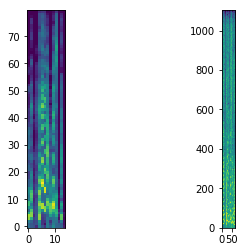

9:18
[b'3/3_4169.wav']
[ 2 20  2 38  2  0  2 33  1 33  2  1 20  0  3 28  8 29  3 20  4  4 20  1
 28  0  7 28  4 40 10 40  2 38  2  0  1 24  7  8 38  4  0  3 38  4  8 24
 18  3 20 52]


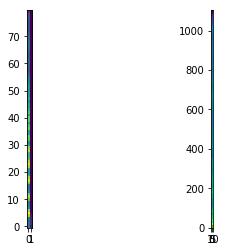

17:66
[b'3/3_4169.wav']
[ 2 20  2 38  2  0  2 33  1 33  2  1 20  0  3 28  8 29  3 20  4  4 20  1
 28  0  7 28  4 40 10 40  2 38  2  0  1 24  7  8 38  4  0  3 38  4  8 24
 18  3 20 52]


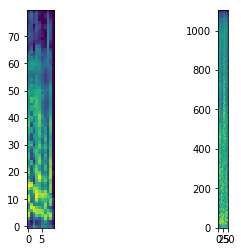

In [180]:
with tf.Session() as sess:    
    for i in range(3):
        y_, mel_, mag_ = sess.run([y, mel, mag])
        print(f)
        print(t)
        plt.subplot(1, 2, 1)
        plt.imshow(mel_.T, origin='lower')
        plt.subplot(1, 2, 2)
        plt.imshow(mag_.T, origin='lower')
        plt.show()

In [181]:
decoder_input = tf.concat((tf.zeros_like(mel[:1, :]), mel[:-1, :]), 0)

In [182]:
decoder_input.set_shape([None, hp.n_mels])

In [183]:
decoder_input

<tf.Tensor 'concat_3:0' shape=(?, 80) dtype=float32>

In [184]:
with tf.variable_scope("embedding", reuse=tf.AUTO_REUSE):
    lookup_table = tf.get_variable('lookup_table', 
                                   dtype=tf.float32, 
                                   shape=[len(hp.vocab), hp.embed_size],
                                   initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))
    

In [185]:
embed_text = tf.nn.embedding_lookup(lookup_table, text_decoded)
embed_text = tf.expand_dims(embed_text, 0)

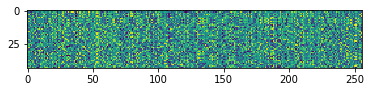

In [186]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(embed_text)
    plt.imshow(x[0, :, :])

In [187]:
with tf.variable_scope("prenet", reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(embed_text, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
    outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 

    prenet_result = outputs

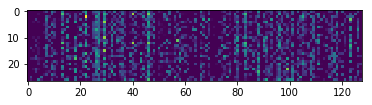

In [188]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(prenet_result)
    plt.imshow(x[0, :, :])

In [189]:
with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
    for k in range(1, hp.K + 1):
        with tf.variable_scope("filter_num_{}".format(k)):
            params = {"inputs":prenet_result, "filters":hp.num_k_filter, "kernel_size":k,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}

            # Works when resue = True
            # For i loop, filter is reused.

            conv_outputs = tf.layers.conv1d(**params)
            if k == 1:
                conv_bank_outputs = conv_outputs
            else:
                conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

    conv_bank_result = conv_bank_outputs

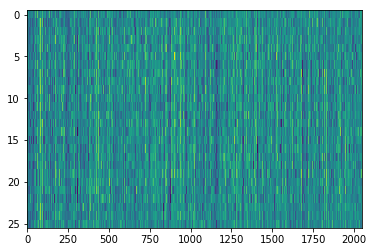

In [190]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_bank_result)
    plt.imshow(x[0, :, :], aspect='auto')

In [191]:
 max_pooling_result = tf.layers.max_pooling1d(conv_bank_result, pool_size=2, strides=1, padding="same")

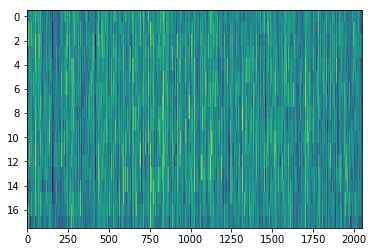

In [192]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(max_pooling_result)
    plt.imshow(x[0, :, :], aspect='auto')

In [193]:
conv_bank_result.shape

TensorShape([Dimension(1), Dimension(None), Dimension(2048)])

In [194]:
with tf.variable_scope("conv1d_1"):       
    params = {"inputs":max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}
    conv_proj_1_result = tf.layers.conv1d(**params)

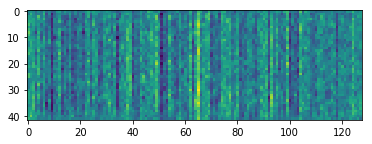

In [195]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_proj_1_result)
    plt.imshow(x[0, :, :])

In [196]:
with tf.variable_scope("conv1d_1"):
    bn_1_result = tf.contrib.layers.batch_norm(inputs=conv_proj_1_result,
                                           center=True,
                                           scale=True,
                                           updates_collections=None,
                                           is_training=True,
                                           scope="conv1d_1",
                                           fused=True,
                                           reuse=tf.AUTO_REUSE)
    batch_norm_1_result = tf.nn.relu(bn_1_result)

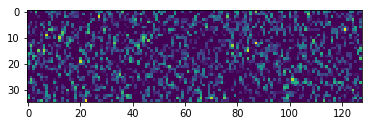

In [197]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(batch_norm_1_result)
    plt.imshow(x[0, :, :])

In [198]:
with tf.variable_scope("conv1d_2"):
    params = {"inputs":batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}
    conv_proj_2_result = tf.layers.conv1d(**params)

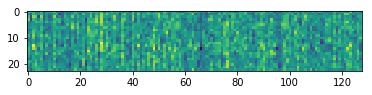

In [199]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_proj_2_result)
    plt.imshow(x[0, :, :])

In [200]:
with tf.variable_scope("conv1d_2"):
    bn_2_result = tf.contrib.layers.batch_norm(inputs=conv_proj_2_result,
                                           center=True,
                                           scale=True,
                                           updates_collections=None,
                                           is_training=True,
                                           scope="conv1d_2",
                                           fused=True,
                                           reuse=tf.AUTO_REUSE)
    batch_norm_2_result = tf.nn.relu(bn_2_result)


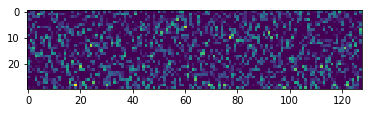

In [201]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(batch_norm_2_result)
    plt.imshow(x[0, :, :])

In [202]:
res_output = prenet_result + batch_norm_2_result

In [203]:
res_output

<tf.Tensor 'add_4:0' shape=(1, ?, 128) dtype=float32>

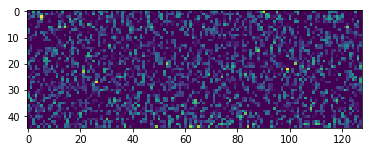

In [204]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(res_output)
    plt.imshow(x[0, :, :])

In [205]:
highwaynet_output = []

for i in range(hp.num_highwaynet_blocks):
    scope = "highwaynet_{:d}".format(i)
    with tf.variable_scope(scope):
        
        if i == 0:
            highwaynet_input = res_output
        else:
            highwaynet_input = highwaynet_output

        H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
        T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                            bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
        highwaynet_output = H*T + highwaynet_input*(1.-T)    

In [206]:
highwaynet_output

<tf.Tensor 'highwaynet_3_3/add:0' shape=(1, ?, 128) dtype=float32>

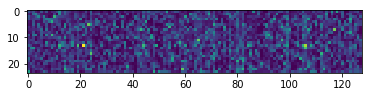

In [207]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(highwaynet_output)
    plt.imshow(x[0, :, :])

In [208]:
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
#     cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
#     cell_bw = tf.contrib.rnn.GRUCell(hp.num_gru_units)
    cell = tf.contrib.rnn.GRUCell(128)
    cell_bw = tf.contrib.rnn.GRUCell(128)

    output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
    gru_result = tf.concat(output, 2)   

In [209]:
gru_result

<tf.Tensor 'gru_5/concat:0' shape=(1, ?, 256) dtype=float32>

In [210]:
decoder_input

<tf.Tensor 'concat_3:0' shape=(?, 80) dtype=float32>

In [211]:
with tf.variable_scope("decoder_prenet", reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(decoder_input, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
    outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
    decoder_prenet_result = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 

In [212]:
decoder_prenet_result

<tf.Tensor 'decoder_prenet_6/dropout2/Identity:0' shape=(?, 128) dtype=float32>

16:98


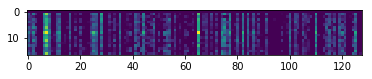

In [213]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(decoder_prenet_result)
    plt.imshow(x)

In [214]:
decoder_prenet_result

<tf.Tensor 'decoder_prenet_6/dropout2/Identity:0' shape=(?, 128) dtype=float32>

In [218]:
gru_result

<tf.Tensor 'gru_5/concat:0' shape=(1, ?, 256) dtype=float32>

In [220]:
decoder_prenet_result_4D

<tf.Tensor 'ExpandDims_9:0' shape=(1, ?, 128) dtype=float32>

In [223]:
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    decoder_prenet_result_4D = tf.expand_dims(decoder_prenet_result, 0)

    attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(hp.num_attention_units, gru_result)
    decoder_cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
    cell_with_attention = tf.contrib.seq2seq.AttentionWrapper(decoder_cell,
                                                              attention_mechanism,
                                                              hp.num_attention_units,
                                                              alignment_history=True)
    dec, state = tf.nn.dynamic_rnn(cell_with_attention, decoder_prenet_result_4D, dtype=tf.float32)
#     dec, state = keras.layers.RNN(cell_with_attention, decoder_prenet_result_4D, dtype=tf.float32)

In [227]:
decoder_prenet_result_4D

<tf.Tensor 'attention_decoder_12/ExpandDims:0' shape=(1, ?, 128) dtype=float32>

In [225]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(state)
    x

TypeError: Fetch argument <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x000001FAD00BBFD0> has invalid type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>, must be a string or Tensor. (Can not convert a TensorArray into a Tensor or Operation.)

In [ ]:
x.shape

In [ ]:
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    alignment = tf.transpose(state.alignment_history.stack(),[1,2,0])

    with tf.variable_scope("decoder_gru_1", reuse=tf.AUTO_REUSE):
        cell = tf.contrib.rnn.GRUCell(128)
        output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
        gru_output_1 = tf.concat(output, 2)

    dec = dec + gru_output_1

    with tf.variable_scope("decoder_gru_2", reuse=tf.AUTO_REUSE):
        cell = tf.contrib.rnn.GRUCell(128)
        output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
        gru_output_2 = tf.concat(output, 2)

    dec = dec + gru_output_2

    # Outputs => (N, T_y/r, n_mels*r)
    y_hat = tf.layers.dense(dec, hp.n_mels*hp.r)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(y_hat)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_input = tf.reshape(y_hat, [1, -1, hp.n_mels])

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
        for k in range(1, hp.K + 1):
            with tf.variable_scope("filter_num_{}".format(k)):
                params = {"inputs":dec_2_input, "filters":hp.num_k_filter, "kernel_size":k,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

                # Works when resue = True
                # For i loop, filter is reused.

                conv_outputs = tf.layers.conv1d(**params)
                if k == 1:
                    conv_bank_outputs = conv_outputs
                else:
                    conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

    dec_2_conv_bank_result = conv_bank_outputs


In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_max_pooling_result = tf.layers.max_pooling1d(dec_2_conv_bank_result, pool_size=2, strides=1, padding="same")

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        params = {"inputs":dec_2_max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        dec_2_conv_proj_1_result = tf.layers.conv1d(**params)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        bn_1_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_1_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_1",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        dec_2_batch_norm_1_result = tf.nn.relu(bn_1_result)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        params = {"inputs":dec_2_batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        dec_2_conv_proj_2_result = tf.layers.conv1d(**params)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        bn_2_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_2_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_2",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        dec_2_batch_norm_2_result = tf.nn.relu(bn_2_result)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_sync_result = tf.layers.dense(dec_2_batch_norm_2_result, 128)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(hp.num_highwaynet_blocks):
        scope = "highwaynet_{:d}".format(i)
        with tf.variable_scope(scope):

            if i == 0:
                highwaynet_input = dec_2_sync_result
            else:
                highwaynet_input = highwaynet_output

            highwaynet_output = []

            H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
            T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
            highwaynet_output = H*T + highwaynet_input*(1.-T)

In [ ]:
with tf.variable_scope("dec_2_gru", reuse=tf.AUTO_REUSE):
    cell = tf.contrib.rnn.GRUCell(128)
    cell_bw = tf.contrib.rnn.GRUCell(128)

    output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
    dec_2_gru_result = tf.concat(output, 2)


In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("final", reuse=tf.AUTO_REUSE):
        z_hat = tf.layers.dense(dec_2_gru_result, 1 + hp.nsc_sec*hp.fs//2)

In [ ]:
z_hat

In [ ]:
mag[0].shape

In [ ]:
loss1 = tf.reduce_mean(tf.abs(y_hat - y))
loss2 = tf.reduce_mean(tf.abs(z_hat - mag))
loss = loss1 + loss2

In [ ]:
loss

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(loss)
    print(x)

In [ ]:
global_step = tf.Variable(0, name='global_step', trainable=False)
lr = learning_rate_decay(hp.lr, global_step=global_step)
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr)

## gradient clipping
gvs = optimizer.compute_gradients(loss)

In [ ]:
clipped = []

for grad, var in gvs:
    if grad is None:
        clipped.append((grad, var))
    else :
        grad = tf.clip_by_norm(grad, 5.)
        clipped.append((grad, var))
    
train_op = optimizer.apply_gradients(clipped, global_step=global_step)

In [ ]:
mode = 'train'

tf.summary.scalar('{}/loss1'.format(mode), loss1)
tf.summary.scalar('{}/loss'.format(mode), loss)
tf.summary.scalar('{}/lr'.format(mode), hp.lr)

tf.summary.image("{}/mel_gt".format(mode), tf.expand_dims(y, -1), max_outputs=1)
tf.summary.image("{}/mel_hat".format(mode), tf.expand_dims(y_hat, -1), max_outputs=1)
tf.summary.image("{}/mag_gt".format(mode), tf.expand_dims(mag, -1), max_outputs=1)
tf.summary.image("{}/mag_hat".format(mode), tf.expand_dims(z_hat, -1), max_outputs=1)

merged = tf.summary.merge_all()

In [ ]:
with tf.Session() as sess:
    for i in range(100):
        sess.run(tf.global_variables_initializer())
        _, gs = sess.run([train_op, global_step])
        print(gs)

In [ ]:
hp.logdir = '.'

In [ ]:
with tf.train.MonitoredTrainingSession(summary_dir=hp.logdir, save_summaries_secs=60) as sess:
    while 1:
        for _ in tqdm(range(100), total=100, ncols=70, leave=False, unit='b'):
            #_, gs = sess.run([train_op, global_step])
            
            _, gs = sess.run([dec_2_sync_result])

            # Write checkpoint files
            if gs % 1000 == 0:
                sv.saver.save(sess, hp.logdir + '/model_gs_{}k'.format(gs//1000))

                # plot the first alignment for logging
                al = sess.run(alignment)
                plt.imshow(al[0])
                ply.show()